# 第 4 章

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math524/blob/main/static_files/presentations/Ch04-classification-lab-zh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math524/blob/main/static_files/presentations/Ch04-classification-lab-zh.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>


In [ ]:
%load_ext cudf.pandas
%load_ext cuml.accel

In [1]:
%pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=b6d57686d9396c0f8f306e6bb044b4d30ede45aa90b49b87a9061590bd7b42ad
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [15]:
# 本 Notebook 使用的匯入（imports）
import numpy as np  # 數值運算與陣列處理
import pandas as pd  # 資料表格與資料處理
from matplotlib.pyplot import subplots  # 建立子圖與繪圖版面
import matplotlib.pyplot as plt  # 繪圖指令與樣式
import seaborn as sns  # 統計視覺化
import statsmodels.api as sm  # 統計模型與推論
from ISLP import load_data, confusion_table  # ISLP：資料載入與混淆表
from ISLP.models import (ModelSpec as MS, contrast, summarize)  # 模型公式與對比
from sklearn.linear_model import LogisticRegression  # 邏輯斯回歸分類器
from sklearn.discriminant_analysis import (  # 判別分析
    LinearDiscriminantAnalysis as LDA,
    QuadraticDiscriminantAnalysis as QDA
)
from sklearn.model_selection import train_test_split  # 訓練/測試資料切分
from sklearn.naive_bayes import GaussianNB  # 高斯樸素貝葉斯
from sklearn.neighbors import KNeighborsClassifier  # KNN 分類器
from sklearn.preprocessing import StandardScaler  # 特徵標準化
from sklearn.metrics import (  # 評估指標與混淆矩陣
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_curve, auc, RocCurveDisplay
)

# 實驗：Logistic Regression、LDA、QDA 與 KNN

## 股票市場資料

在這個實驗中，我們將檢視 [`Smarket`](https://islp.readthedocs.io/en/latest/datasets/Smarket.html) 資料集，這是 ISLP 套件庫的一部分。這個資料集包含 S&P 500 股價指數在 1,250 天期間（從 2001 年初到 2005 年底）的百分比報酬率。對於每個日期，我們記錄了前五個交易日的百分比報酬率 `Lag1` 到 `Lag5`。我們也記錄了 `Volume`（前一日的成交股數，以十億為單位）、`Today`（該日的百分比報酬率）以及 `Direction`（該日市場是上漲 `Up` 還是下跌 `Down`）。

我們從頂層開始匯入函式庫；這些都是在之前實驗中已見過的匯入項目。

我們必須重新啟動執行環境才能使用新安裝的版本！

In [3]:
%matplotlib inline
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

現在我們準備載入 `Smarket` 資料。

In [4]:
Smarket = load_data('Smarket')
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


這給出了截斷的資料表。
我們可以看看變數名稱是什麼。

In [5]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [6]:
Smarket.describe(include='all')

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000,1250
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,648
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138,NaN
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334,NaN
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000,NaN
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500,NaN
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500,NaN
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750,NaN


In [7]:
Smarket.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Year       1250 non-null   int64   
 1   Lag1       1250 non-null   float64 
 2   Lag2       1250 non-null   float64 
 3   Lag3       1250 non-null   float64 
 4   Lag4       1250 non-null   float64 
 5   Lag5       1250 non-null   float64 
 6   Volume     1250 non-null   float64 
 7   Today      1250 non-null   float64 
 8   Direction  1250 non-null   category
dtypes: category(1), float64(7), int64(1)
memory usage: 79.7 KB


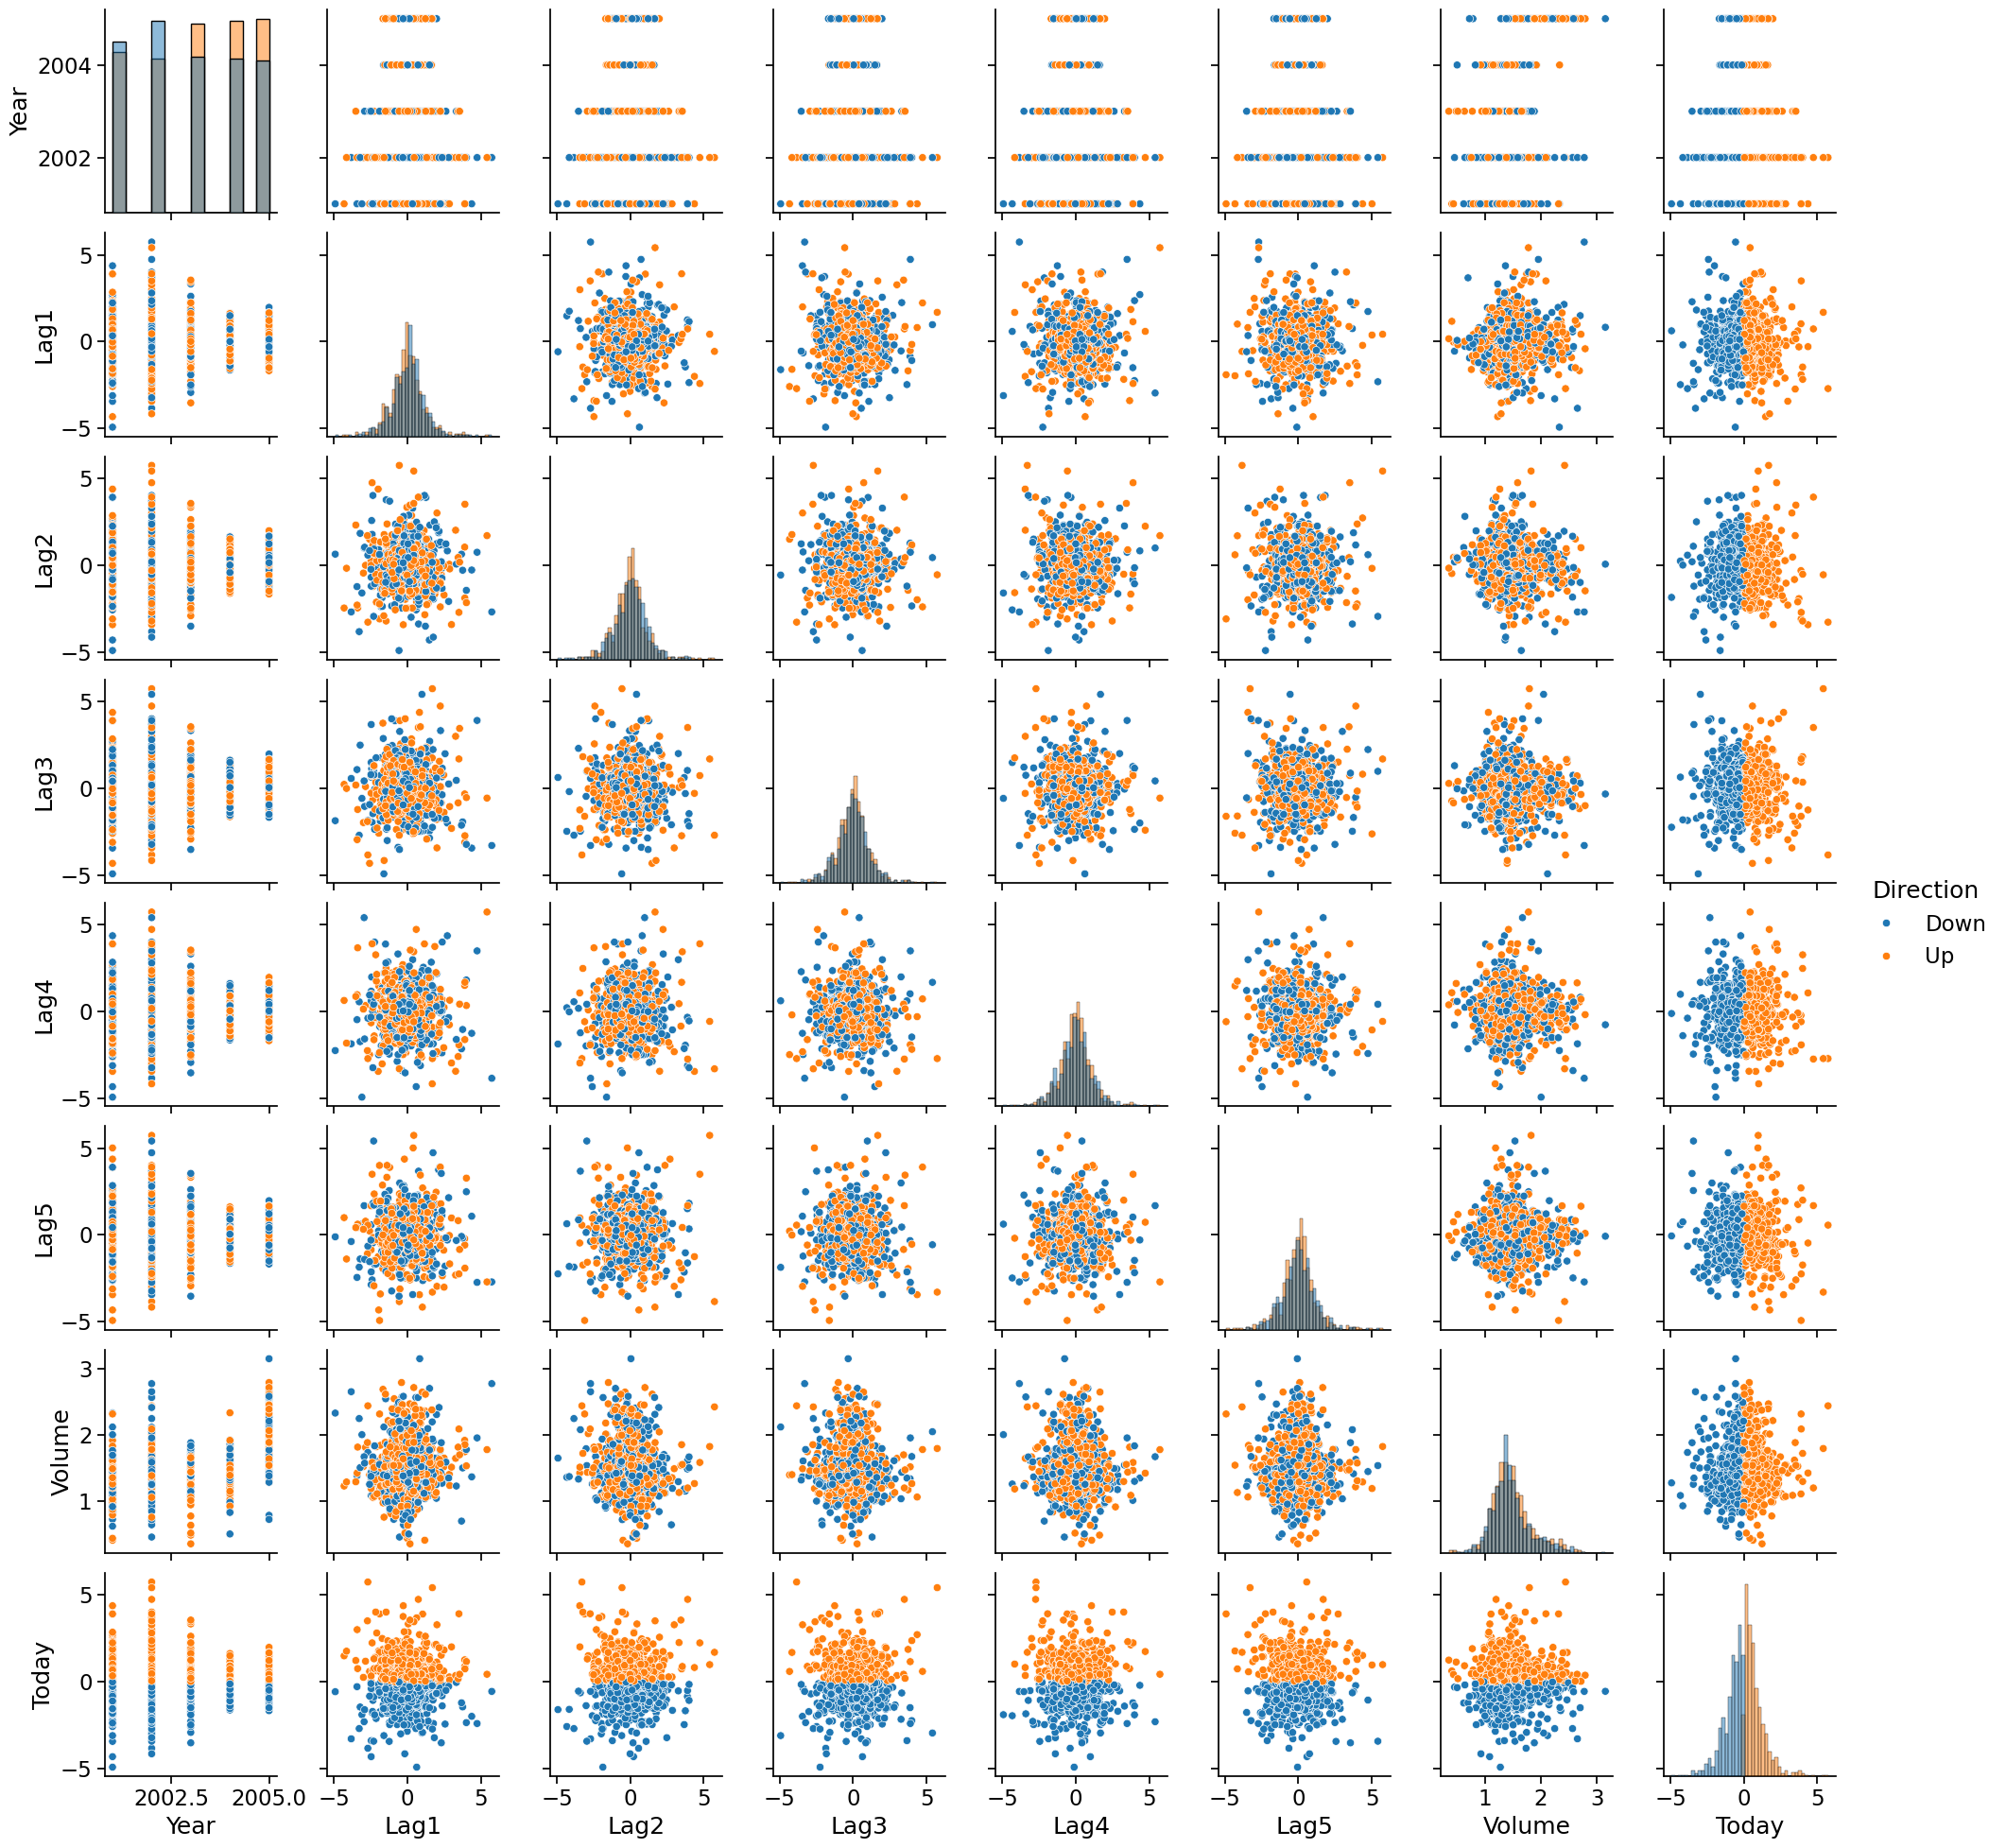

In [8]:
sns.pairplot(data=Smarket, hue='Direction', diag_kind='hist');

我們使用資料表的 `corr()` 方法來計算相關矩陣，這會產生一個包含所有變數之間成對相關性的矩陣。

透過指示 `pandas` 只使用數值變數，`corr()` 方法不會報告 `Direction` 變數的相關性，因為它是分類變數。

In [9]:
corr = Smarket.corr(numeric_only=True)
corr

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


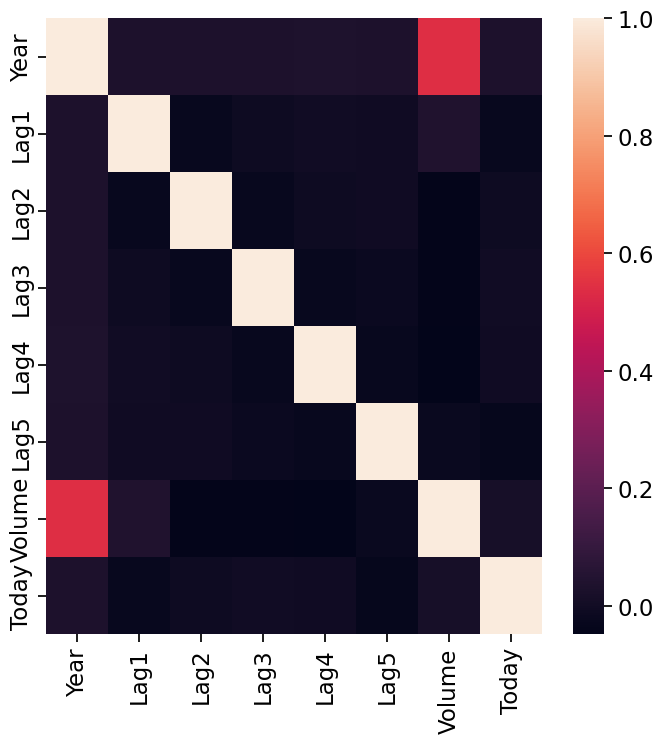

In [10]:
# the best way to visualize corerelations matrices is heatmap
plt.figure(figsize = (8,8))
sns.heatmap(corr);

如預期的，落後報酬變數與今日報酬之間的相關性接近零。唯一顯著的相關性是 `Year` 和 `Volume` 之間。透過繪製資料我們可以看到 `Volume` 隨時間增加。換句話說，從 2001 年到 2005 年，每日平均交易股數增加了。

In [11]:
print(corr.iloc[:,-2:])

          Volume     Today
Year    0.539006  0.030095
Lag1    0.040910 -0.026155
Lag2   -0.043383 -0.010250
Lag3   -0.041824 -0.002448
Lag4   -0.048414 -0.006900
Lag5   -0.022002 -0.034860
Volume  1.000000  0.014592
Today   0.014592  1.000000


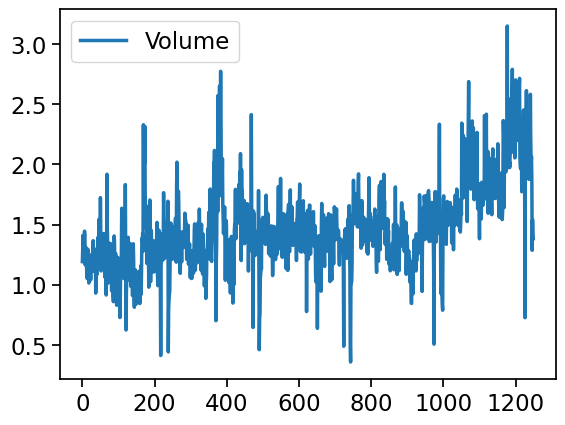

In [12]:
Smarket.plot(y='Volume');

## Logistic Regression（邏輯迴歸）

接下來我們將擬合一個 logistic regression 模型來使用 `Lag1` 到 `Lag5` 以及 `Volume` 來預測 `Direction`。`sm.GLM()` 函數擬合*廣義線性模型*，這是一類包含邏輯迴歸的模型。或者，`sm.Logit()` 函數直接擬合 logistic regression 模型。`sm.GLM()` 的語法與 `sm.OLS()` 類似，除了我們必須傳入參數 `family=sm.families.Binomial()` 來告訴 `statsmodels` 執行邏輯迴歸而非其他類型的廣義線性模型。

In [16]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


這裡最小的 *p* 值與 `Lag1` 相關。這個預測變數的負係數表示，如果市場昨日有正報酬，那麼今日上漲的可能性較低。然而，在 0.15 的值下，*p* 值仍然相對較大，因此沒有明確證據顯示 `Lag1` 和 `Direction` 之間存在真實的關聯性。

我們使用 `results` 的 `params` 屬性來存取這個擬合模型的係數。參見 [https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLMResults.html](https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLMResults.html)。

In [17]:
results.params

,0
intercept,-0.126000
Lag1,-0.073074
Lag2,-0.042301
Lag3,0.011085
Lag4,0.009359
Lag5,0.010313
Volume,0.135441


同樣地，我們可以使用 `pvalues` 屬性來存取係數的 *p* 值。

In [18]:
results.pvalues

,0
intercept,0.600700
Lag1,0.145232
Lag2,0.398352
Lag3,0.824334
Lag4,0.851445
Lag5,0.834998
Volume,0.392404


可以使用 `results` 的 `predict()` 方法來預測給定預測變數值時市場上漲的機率。這個方法在機率尺度上回傳預測結果。如果沒有資料集提供給 `predict()` 函數，那麼機率會針對用來擬合邏輯迴歸模型的訓練資料計算。如同線性迴歸，如果需要的話可以傳入一個選擇性的 `exog` 參數與設計矩陣一致。這裡我們只印出前十個機率。

In [19]:
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

為了對特定日期的市場是上漲還是下跌做出預測，我們必須將這些預測機率轉換成分類標籤 `Up` 或 `Down`。以下兩個指令根據預測的市場上漲機率是否大於或小於 0.5 來建立分類預測向量。

In [20]:
labels = np.array(['Down']*1250)
labels[probs>0.5] = "Up"

來自 ISLP 套件的 `confusion_table()` 函數彙總這些預測，顯示有多少觀測值被正確或錯誤分類。我們的函數改編自 `scikit-learn.metrics` 模組中的類似函數，會轉置結果矩陣並包含列和欄標籤。
**`confusion_table()` 函數第一個參數是預測標籤，第二個參數是真實標籤。**

In [21]:
confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


或者我們可以直接使用 `scikit-learn` 提供的版本，**慣例是使用轉置版本（第一個參數是真實標籤，第二個參數是預測標籤）**：

In [22]:
cm = confusion_matrix(Smarket.Direction, labels) # True, predicted
cm

array([[145, 457],
       [141, 507]])

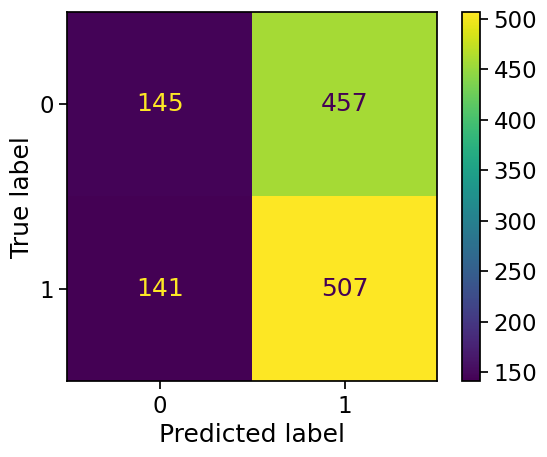

In [23]:
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot();

In [24]:
print(classification_report(Smarket.Direction, labels, digits=3))

              precision    recall  f1-score   support

        Down      0.507     0.241     0.327       602
          Up      0.526     0.782     0.629       648

    accuracy                          0.522      1250
   macro avg      0.516     0.512     0.478      1250
weighted avg      0.517     0.522     0.483      1250



混淆矩陣（confusion matrix）的對角線元素表示正確預測，而非對角線元素表示錯誤預測。因此我們的模型正確預測了 507 天的市場上漲和 145 天的市場下跌，總共 507 + 145 = 652 次正確預測。`np.mean()` 函數可以用來計算預測正確的天數比例。在這個案例中，邏輯迴歸正確預測市場走勢的時間為 52.2%。

In [25]:
(507+145)/1250, np.mean(labels == Smarket.Direction)

(0.5216, np.float64(0.5216))

乍看之下，邏輯迴歸模型似乎只比隨機猜測好一點點。然而，這個結果是誤導的，因為我們在同一組 1,250 個觀測值上訓練和測試模型。換句話說，$100-52.2=47.8%$ 是*訓練*錯誤率。如我們之前所見，訓練錯誤率往往過度樂觀——它傾向於低估測試錯誤率。為了更好地評估邏輯迴歸模型在這個設定下的準確率，我們可以使用部分資料擬合模型，然後檢視它對*保留資料*的預測表現如何。這將產生更實際的錯誤率，在實務上我們感興趣的是模型在未來市場走勢未知的日子裡的表現，而不是在用來擬合模型的資料上的表現。

為了實施這個策略，我們首先建立一個對應 2001 年到 2004 年觀測值的布林向量。然後我們使用這個向量建立來自 2005 年觀測值的保留資料集。

In [26]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

物件 `train` 是一個包含 1,250 個元素的向量，對應我們資料集中的觀測值。對應 2005 年前發生的觀測值的向量元素被設定為 `True`，而對應 2005 年觀測值的則設定為 `False`。因此 `train` 是一個*布林*陣列，因為它的元素是 `True` 和 `False`。布林陣列可以用來使用 `loc` 方法取得資料表的列或欄子集。例如，指令 `Smarket.loc[train]` 會挑選出股市資料集的子矩陣，只對應 2005 年前的日期，因為這些是 `train` 元素為 `True` 的情況。`~` 符號可以用來否定布林向量的所有元素。也就是說，`~train` 是一個類似 `train` 的向量，除了在 `train` 中為 `True` 的元素在 `~train` 中會被交換為 `False`，反之亦然。因此，`Smarket.loc[~train]` 會產生資料表的子集列，只包含 `train` 為 `False` 的股市資料觀測值。上面的輸出顯示有 252 個這樣的觀測值。

現在我們只使用對應 2005 年前日期的觀測值子集來擬合邏輯迴歸模型。然後我們獲得測試集中每個日子（即 2005 年的日子）股市上漲的預測機率。

In [27]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

注意我們在兩個完全分離的資料集上訓練和測試我們的模型：訓練只使用 2005 年前的日期，測試只使用 2005 年的日期。

最後，我們比較 2005 年的預測與該時間段的實際市場走勢。我們將首先儲存測試和訓練標籤（回想 `y_test` 是二元的）。

In [28]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]

現在我們將擬合機率以 50% 為閾值來形成我們的預測標籤。

In [29]:
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


測試準確率大約是 48%，而錯誤率大約是 52%

In [30]:
np.mean(labels == L_test), np.mean(labels != L_test)

(np.float64(0.4801587301587302), np.float64(0.5198412698412699))

`!=` 符號表示*不等於*，所以最後一個指令計算測試集錯誤率。結果相當令人失望：測試錯誤率是 52%，比隨機猜測還差！當然這個結果並不那麼令人意外，因為一般來說不會預期能夠使用前幾天的報酬來預測未來的市場表現。（畢竟，如果可能做到這一點，這本書的作者們會忙著投資，而不會來寫統計教科書。）

我們回想邏輯迴歸模型與所有預測變數相關的 *p* 值都很不理想，而最小的 *p* 值（雖然不是很小）對應到 `Lag1`。或許透過移除那些在預測 `Direction` 上似乎沒有幫助的變數，我們可以獲得更有效的模型。畢竟，使用與反應變數沒有關係的預測變數往往會導致測試錯誤率惡化（因為這樣的預測變數會造成變異數增加而沒有對應的偏誤減少），因此移除這樣的預測變數可能會帶來改善。下面我們僅使用 `Lag1` 和 `Lag2` 重新擬合邏輯迴歸，這兩個變數在原始邏輯迴歸模型中似乎具有最高的預測力。

In [31]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


讓我們評估整體準確率以及邏輯迴歸預測上漲日子的準確率。

In [32]:
(35+106)/252, 106/(106+76)

(0.5595238095238095, 0.5824175824175825)

我們可以在 scikit-learn 模組中找到許多有用的評估指標 [https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)。

In [33]:
conf_mat = confusion_matrix(L_test, labels) # True, predicted
print(conf_mat)

[[ 35  76]
 [ 35 106]]


In [34]:
TP = conf_mat[1,1]
TN = conf_mat[0,0]
FP = conf_mat[0,1]
FN = conf_mat[1,0]

# print("Accuracy: ", conf_mat.diagonal().sum()/conf_mat.sum() )
print("Accuracy: ", (TP+TN) / (TP+TN+FP+FN) )
print("Sensitivity: ",  TP / (FN + TP) )
print("Precision: ",  TP / (FP + TP) )
print("False Positive Rate: ",  FP / (FP + TN) )

Accuracy:  0.5595238095238095
Sensitivity:  0.75177304964539
Precision:  0.5824175824175825
False Positive Rate:  0.6846846846846847


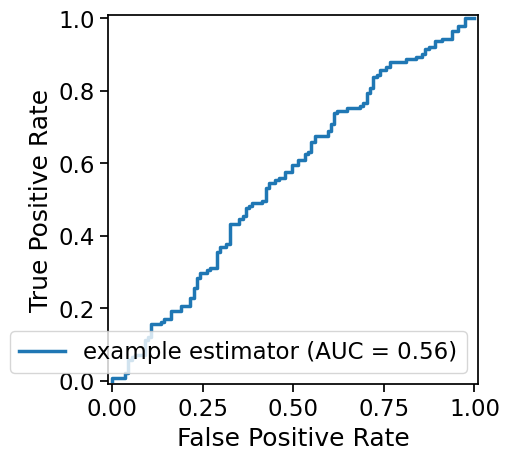

In [35]:
fpr, tpr, thresholds = roc_curve(L_test, probs, pos_label='Up')
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator').plot();

現在結果看起來好一點：56% 的每日走勢被正確預測。值得注意的是，在這種情況下，預測市場每天都會上漲這種簡單得多的策略也會有 56% 的正確率！因此，就整體錯誤率而言，邏輯迴歸方法並不比直覺方法好。然而，混淆矩陣顯示在邏輯迴歸預測市場上漲的日子裡，它有 58% 的準確率。這暗示了一個可能的交易策略：在模型預測市場上漲時買進，在預測下跌時避免交易。當然，需要更仔細地調查這個小改善是真實的還是僅因隨機機會。

假設我們想要預測與 `Lag1` 和 `Lag2` 特定值相關的報酬。特別是，我們想要預測當 `Lag1` 和 `Lag2` 分別等於 $1.2$ 和 $1.1$ 的日子，以及它們分別等於 $1.5$ 和 $-0.8$ 的日子的 `Direction`。我們使用 `predict()` 函數來做到這一點。

In [36]:
newdata = pd.DataFrame({'Lag1':[1.2, 1.5],
                        'Lag2':[1.1, -0.8]});
newX = model.transform(newdata)
results.predict(newX)

,0
0,0.479146
1,0.496094


## Linear Discriminant Analysis（線性判別分析）

我們開始對 `Smarket` 資料執行 LDA，使用 `LinearDiscriminantAnalysis()` 函數，我們將其縮寫為 `LDA()`。我們只使用 2005 年前的觀測值來擬合模型。

In [37]:
lda = LDA(store_covariance=True)

由於 `LDA` 估計器自動添加截距，我們應該移除 `X_train` 和 `X_test` 中對應截距的欄。我們也可以直接使用標籤而非布林向量 `y_train`。

In [38]:
X_train, X_test = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

這裡我們使用了在第 3.6.4 節中介紹的串列生成式。看我們上面的第一行，我們看到右邊是一個長度為二的串列。這是因為程式碼 `for M in [X_train, X_test]` 對長度為二的串列進行迭代。雖然這裡我們對串列進行迴圈，但串列生成式方法在對任何可迭代物件進行迴圈時都有效。然後我們將 `drop()` 方法應用於迭代中的每個元素，將結果收集在串列中。左邊告訴 Python 解壓這個長度為二的串列，將其元素指派給變數 `X_train` 和 `X_test`。當然，這會覆蓋 `X_train` 和 `X_test` 的先前值。

擬合模型後，我們可以用 `means_` 屬性提取兩個類別中的平均值。這些是每個預測變數在每個類別中的平均值，被 LDA 用作 $\mu_k$ 的估計值。這些結果表明，在市場上漲的日子裡，前 2 天的報酬傾向為負，而在市場下跌的日子裡，前幾天的報酬傾向為正。

In [39]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

估計的先驗機率儲存在 `priors_` 屬性中。套件 `scikit-learn` 通常使用尾隨的 `_` 來表示使用 `fit()` 方法時估計的量。我們可以透過查看 `classes_` 屬性來確定哪個條目對應哪個標籤。

In [40]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

LDA 輸出顯示 $\hat\pi_{Down}=0.492$ 和 $\hat\pi_{Up}=0.508$。

In [41]:
lda.priors_

array([0.49198397, 0.50801603])

線性判別向量可以在 `scalings_` 屬性中找到：

In [42]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

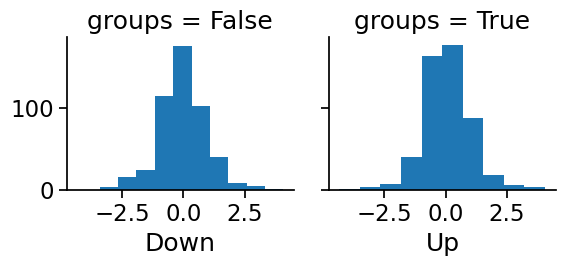

In [43]:
# for plotting lda
ld_sc = X_train.iloc[:, 0] * lda.scalings_[0] + X_train.iloc[:, 1] * lda.scalings_[1]

ld = pd.DataFrame({'groups': y_train, 'ld': ld_sc})

g = sns.FacetGrid(ld, col='groups')
g.map(plt.hist, 'ld')
ax1, ax2 = g.axes[0]
ax1.set_xlabel("Down")
ax2.set_xlabel("Up");

這些值提供 `Lag1` 和 `Lag2` 的線性組合，用於形成 LDA 決策規則。換句話說，這些是 (4.24) 中 $X=x$ 元素的乘數。如果 $-0.64\times `Lag1` - 0.51 \times `Lag2`$ 很大，那麼 LDA 分類器將預測市場上漲，如果它很小，那麼 LDA 分類器將預測市場下跌。

In [44]:
lda_pred = lda.predict(X_test)

如我們在分類方法比較（第 4.5 節）中觀察到的，LDA 和邏輯迴歸預測幾乎相同。

In [45]:
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


我們也可以估計訓練集中每個點屬於每個類別的機率。對後驗機率屬於類別一應用 50% 閾值允許我們重現包含在 `lda_pred` 中的預測。

In [46]:
lda_prob = lda.predict_proba(X_test)
np.all(
       np.where(lda_prob[:,1] >= 0.5, 'Up','Down') == lda_pred
       )

np.True_

上面我們使用了 `np.where()` 函式，該函式建立一個陣列，對於 `lda_prob` 第二欄（估計的 `'Up'` 後驗機率）大於 0.5 的索引，其值為 `'Up'`。對於超過兩個類別的問題，標籤會被選為後驗機率最高的類別：

In [47]:
np.all(
       [lda.classes_[i] for i in np.argmax(lda_prob, 1)] == lda_pred
       )

np.True_

如果我們想使用 50% 以外的後驗機率閾值來進行預測，我們可以輕易做到。例如，假設我們希望只有在非常確定市場確實會在當天下跌時才預測市場下跌——也就是說，如果後驗機率至少為 90%。檢查 `classes_` 屬性後，我們知道 `lda_prob` 的第一欄對應標籤 `Down`，因此我們使用欄索引 0 而不是像上面那樣使用 1。

In [48]:
np.sum(lda_prob[:,0] > 0.9)

np.int64(0)

2005 年沒有任何一天滿足該閾值！實際上，2005 年全年的最大下跌後驗機率是 52.02%。

上述的 LDA 分類器是來自 `scikit-learn` 函式庫的第一個分類器。我們將使用該函式庫中的其他幾個物件。這些物件遵循共同的結構，簡化了諸如交叉驗證等任務，我們將在第 5 章中看到。具體而言，這些方法首先建立通用分類器而不參照任何資料。然後使用 `fit()` 方法將這個分類器擬合資料，並且總是使用 `predict()` 方法產生預測。這種首先實例化分類器、然後擬合它、接著產生預測的模式是 `scikit-learn` 的明確設計選擇。這種一致性使得能夠乾淨地複製分類器，讓它可以擬合不同的資料；例如，交叉驗證中產生的不同訓練集。這種標準模式也允許形成可預測的工作流程。

## Quadratic Discriminant Analysis（二次判別分析）

我們將現在對 `Smarket` 資料擬合 QDA 模型。QDA 是透過 `scikit-learn` 套件中的 `QuadraticDiscriminantAnalysis()` 實作的，我們將其縮寫為 `QDA()`。語法與 `LDA()` 非常類似。

In [49]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

`QDA()` 函數將再次計算 `means_` 和 `priors_`。

In [50]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

`QDA()` 分類器會為每個類別估計一個共變數矩陣。這是第一個類別的估計共變數矩陣：

In [51]:
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

輸出包含分組平均值。但它不包含線性判別式的係數，因為 QDA 分類器涉及預測變數的二次而非線性函式。`predict()` 函式的運作方式與 LDA 完全相同。

In [52]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


有趣的是，QDA 預測的準確率接近 60%，儘管 2005 年的資料並未用於擬合模型。

In [53]:
np.mean(qda_pred == L_test)

np.float64(0.5992063492063492)

In [54]:
print('Accuracy using QDA is ',accuracy_score(L_test, qda_pred))

Accuracy using QDA is  0.5992063492063492


對於股市資料來說，這個準確率水準相當令人印象深刻，因為股市資料以難以準確建模而聞名。這表明 QDA 假設的二次形式可能比 LDA 和邏輯迴歸假設的線性形式更準確地捕捉到真實關係。然而，我們建議在將這種方法持續擊敗市場之前，先在較大的測試集上評估此方法的表現！

## Naive Bayes


接下來我們對 `Smarket` 資料擬合 naive Bayes 模型。語法與 `LDA()` 和 `QDA()` 類似。預設情況下，naive Bayes 分類器的 `GaussianNB()` 實作使用高斯分布來建模每個定量特徵。然而，核密度方法也可以用來估計分布。

In [55]:
NB = GaussianNB()
NB.fit(X_train, L_train)

GaussianNB()

類別儲存為 `classes_`。

In [56]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

類別先驗機率儲存在 `class_prior_` 屬性中。

In [57]:
NB.class_prior_

array([0.49198397, 0.50801603])

特徵的參數可以在 `theta_` 和 `var_` 屬性中找到。列數等於類別數，而欄數等於特徵數。我們看到下面 `Down` 類別中特徵 `Lag1` 的平均值是 0.043。

In [58]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

其變異數是 1.503。

In [59]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

我們如何知道這些屬性的名稱？我們使用 `NB?`（或 `?NB`）。

我們可以輕易驗證平均值計算：

In [60]:
X_train[L_train == 'Down'].mean()

,0
Lag1,0.042790
Lag2,0.033894


變異數也類似：

In [61]:
X_train[L_train == 'Down'].var(ddof=0)

,0
Lag1,1.503554
Lag2,1.532467


由於 `NB()` 是 `scikit-learn` 函式庫中的分類器，進行預測使用與上述 `LDA()` 和 `QDA()` 相同的語法。

In [62]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


In [63]:
print('Accuracy using gnb is ',accuracy_score(L_test,nb_labels))

Accuracy using gnb is  0.5952380952380952


Naive Bayes 在這些資料上表現良好，準確預測超過 59% 的時間。這比 QDA 稍微差一點，但比 LDA 好得多。

如同 `LDA`，`predict_proba()` 方法估計每個觀測值屬於特定類別的機率。

In [64]:
NB.predict_proba(X_test)[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

## K-Nearest Neighbors（K-最近鄰居）

我們將現在使用 `KNeighborsClassifier()` 函數執行 KNN。這個函數的運作方式與我們迄今遇到的其他模型擬合函數類似。

如同 LDA 和 QDA，我們使用 `fit` 方法擬合分類器。使用由 `fit()` 回傳的物件的 `predict` 方法形成新的預測。

In [65]:
knn1 = KNeighborsClassifier(n_neighbors=1)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


使用 $K=1$ 的結果不是很好，因為只有 $50\%$ 的觀測值被正確預測。當然，這可能是 $K=1$ 導致對資料過度靈活的擬合。

In [66]:
(83+43)/252, np.mean(knn1_pred == L_test)

(0.5, np.float64(0.5))

In [67]:
print(classification_report(L_test, knn1_pred, digits=3))

              precision    recall  f1-score   support

        Down      0.426     0.387     0.406       111
          Up      0.550     0.589     0.568       141

    accuracy                          0.500       252
   macro avg      0.488     0.488     0.487       252
weighted avg      0.495     0.500     0.497       252



我們在下面使用 $K=3$ 重複分析。

In [68]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(X_train, L_train).predict(X_test)
np.mean(knn3_pred == L_test)

np.float64(0.5317460317460317)

In [69]:
print(classification_report(L_test, knn3_pred, digits=3))

              precision    recall  f1-score   support

        Down      0.466     0.432     0.449       111
          Up      0.577     0.610     0.593       141

    accuracy                          0.532       252
   macro avg      0.522     0.521     0.521       252
weighted avg      0.528     0.532     0.529       252



結果有輕微改善。但進一步增加 *K* 並沒有進一步改善。看起來對於這些資料和這個訓練/測試分割，QDA 在我們迄今檢驗的方法中給出最好的結果。

KNN 在 `Smarket` 資料上表現不佳，但它經常提供令人印象深刻的結果。作為一個例子，我們將 KNN 方法應用於 [`Caravan`](https://islp.readthedocs.io/en/latest/datasets/Caravan.html) 資料集，這是 ISLP 函式庫的一部分。這個資料集包含 85 個預測變數，測量 5,822 個個體的人口統計特徵。反應變數是 `Purchase`，它指示給定個體是否購買大篷車保險。在這個資料集中，只有 6% 的人購買了大篷車保險。

In [70]:
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
Purchase.value_counts()

,count
Purchase,
No,5474
Yes,348


`value_counts()` 方法接受一個 `pd.Series` 或 `pd.DataFrame`，並回傳一個 `pd.Series`，包含每個唯一元素的對應計數。在這個情況下，`Purchase` 只有 `Yes` 和 `No` 值，該方法回傳每個值有多少個。

In [71]:
348 / 5822

0.05977327378907592

我們的特徵將包括除了 `Purchase` 以外的所有欄位。

In [72]:
feature_df = Caravan.drop(columns=['Purchase'])

因為 KNN 分類器透過識別與測試觀測值最近的觀測值來預測類別，變數的尺度很重要。任何處於大尺度的變數對觀測值之間的*距離*會有更大的影響，因此對 KNN 分類器的影響也比處於小尺度的變數更大。例如，想像一個包含兩個變數的資料集，`salary` 和 `age`（分別以美元和年為單位測量）。就 KNN 而言，薪資相差 1,000 美元與年齡相差 50 歲相比是巨大的。因此，`salary` 將主導 KNN 分類結果，而 `age` 幾乎沒有影響。這與我們的直覺相反，我們直覺上認為薪資相差 1,000 美元與年齡相差 50 歲相比是相當小的。此外，KNN 分類器中尺度的重要性導致另一個問題：如果我們用日圓測量 `salary`，或者用分鐘測量 `age`，那麼我們會得到與用美元和年測量這兩個變數時截然不同的分類結果。

處理這個問題的好方法是*標準化*資料，使所有變數都具有平均值為零、標準差為一。那麼所有變數將處於可比較的尺度上。這可以使用 `StandardScaler()` 轉換來達成。

In [73]:
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)

參數 `with_mean` 指示是否應該減去平均值，而 `with_std` 指示是否應該縮放欄位使其標準差為 1。最後，參數 `copy=True` 指示我們將總是複製資料，而不是盡可能在原地進行計算。

這個轉換可以擬合，然後應用於任意資料。在下面的第一行中，縮放的參數被計算並儲存在 `scaler` 中，而第二行實際上構建標準化的特徵集合。

In [74]:
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

現在下面 `feature_std` 的每一欄都有標準差為一和平均值為零。

In [75]:
feature_std = pd.DataFrame(
                 X_std,
                 columns=feature_df.columns);
feature_std.std()

,0
MOSTYPE,1.000086
MAANTHUI,1.000086
MGEMOMV,1.000086
MGEMLEEF,1.000086
MOSHOOFD,1.000086
...,...
AZEILPL,1.000086
APLEZIER,1.000086
AFIETS,1.000086
AINBOED,1.000086


注意這裡的標準差不完全是 $1$；這同樣是由於某些程序使用 $1/n$ 慣例來計算變異數（在這種情況下是 `scaler()`），而其他程序使用 $1/(n-1)$（`std()` 方法）。請參見第 200 頁的註腳。在這種情況下這並不重要，只要變數都在相同的尺度上。

使用 `train_test_split()` 函式，我們現在將觀測值分割為包含 1000 個觀測值的測試集和包含其餘觀測值的訓練集。參數 `random_state=0` 確保我們每次重新執行程式碼時得到相同的分割。

In [76]:
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(np.asarray(feature_std),
                            Purchase,
                            test_size=1000,
                            random_state=0)

`?train_test_split` 顯示非關鍵字參數可以是 `lists`、`arrays`、`pandas dataframes` 等，它們都具有相同的長度（`shape[0]`），因此是*可索引的*。在這種情況下，它們是資料表 `feature_std` 和反應變數 `Purchase`。
{注意：我們已將 `feature_std` 轉換為 `ndarray` 以解決 `scikit-learn` 中的錯誤。}

我們在訓練資料上使用 $K=1$ 擬合 KNN 模型，並評估其在測試資料上的效能。

In [77]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train, y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

(np.float64(0.111), np.float64(0.067))

KNN 在 1,000 個測試觀測值上的錯誤率約為 $11%$。乍看之下，這似乎相當不錯。然而，由於只有剛好超過 6% 的客戶購買了保險，我們可以藉由總是預測 `No`（無論預測變數的值如何）將錯誤率降低到幾乎 6%！這被稱為*虛無率*。

假設嘗試向給定個人銷售保險存在某些不小的成本。例如，或許銷售員必須拜訪每位潛在客戶。如果公司嘗試向隨機選擇的客戶銷售保險，那麼成功率將只有 6%，考慮到涉及的成本，這可能太低了。相反，公司希望只嘗試向可能購買保險的客戶銷售保險。所以整體錯誤率不是重點。相反，被正確預測會購買保險的個人比例才是重點。

In [78]:
confusion_table(knn1_pred, y_test)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


結果發現，在被預測會購買保險的客戶中，KNN $K=1$ 的表現遠比隨機猜測要好。在 62 個這樣的客戶中，有 9 個（即 14.5%）實際購買了保險。這是隨機猜測所能獲得的兩倍率。

In [79]:
9/(53+9)

0.14516129032258066

### 調整參數

KNN 中的鄰居數被稱為*調整參數*，也被稱為*超參數*。我們不知道先驗地應該使用什麼值。因此，看看分類器在測試資料上的表現如何隨著這些參數的變化而變化是有趣的。這可以透過第 2.3.8 節中描述的 `for` 迴圈來達成。這裡我們使用 for 迴圈來查看我們的分類器在被預測購買保險的群組中的準確率，當我們將鄰居數從 1 變化到 5 時：

In [80]:
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to rent: {1:>2},' +
            '  # who did rent {2:d}, accuracy {3:.1%}')
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes','Yes']
    print(templ.format(
          K,
          pred,
          did_rent,
          did_rent / pred))

K=1: # predicted to rent: 62,  # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6,  # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 20,  # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4,  # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7,  # who did rent 1, accuracy 14.3%


我們看到一些變化性——`K=4` 的數字與其餘的非常不同。

### 與邏輯迴歸的比較

作為比較，我們也可以對資料擬合邏輯迴歸模型。這也可以使用 `scikit-learn` 來完成，不過預設情況下它擬合的是類似*嶺迴歸*版本的邏輯迴歸，我們在第 6 章中介紹。這可以透過適當設定下面的參數 `C` 來修改。其預設值是 1，但透過將其設定為非常大的數字，演算法會收斂到與上面討論的常見（未正則化）邏輯迴歸估計器相同的解。

與 `statsmodels` 套件不同，`scikit-learn` 較少專注於推論而更多專注於分類。因此，在 `statsmodels` 中看到的 `summary` 方法以及我們使用 `summarize` 看到的簡化版本通常不適用於 `scikit-learn` 中的分類器。

In [81]:
logit = LogisticRegression(C=1e10, solver='liblinear')
logit.fit(X_train, y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred[:,1] > .5, 'Yes', 'No')
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,931,67
Yes,2,0


我們在上面使用了參數 `solver='liblinear'` 來避免預設求解器的警告，該警告會指示演算法不收斂。

如果我們使用 $0.5$ 作為分類器的預測機率截止值，那麼我們就有問題：只有兩個測試觀測值被預測會購買保險。然而，我們不需要使用截止值 $0.5$。如果我們改為在預測購買機率超過 $0.25$ 時就預測會購買，我們會得到更好的結果：我們預測 29 個人會購買保險，而我們對其中約 31% 的人是正確的。這比隨機猜測好了將近五倍！

In [82]:
logit_labels = np.where(logit_pred[:,1]>0.25, 'Yes', 'No')
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,913,58
Yes,20,9


In [83]:
9/(20+9)

0.3103448275862069

## 在 Bikeshare 資料上的 Linear 和 Poisson Regression

這裡我們對 [`Bikeshare`](https://islp.readthedocs.io/en/latest/datasets/Bikeshare.html) 資料擬合線性和泊松迴歸模型，如第 4.6 節所述。反應變數 `bikers` 測量 2010-2012 年期間華盛頓特區每小時的自行車租賃數量。

In [84]:
Bike = load_data('Bikeshare')

讓我們看看這個資料表的維度和變數名稱。

In [85]:
Bike.shape, Bike.columns

((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

### Linear Regression

我們開始對資料擬合線性迴歸模型。

In [86]:
X = MS(['mnth',
        'hr',
        'workingday',
        'temp',
        'weathersit']).fit_transform(Bike)
Y = Bike['bikers']
M_lm = sm.OLS(Y, X).fit()
summarize(M_lm)

,coef,std err,t,P>|t|
intercept,-68.6317,5.307,-12.932,0.000
mnth[Feb],6.8452,4.287,1.597,0.110
mnth[March],16.5514,4.301,3.848,0.000
mnth[April],41.4249,4.972,8.331,0.000
mnth[May],72.5571,5.641,12.862,0.000
mnth[June],67.8187,6.544,10.364,0.000
mnth[July],45.3245,7.081,6.401,0.000
mnth[Aug],53.2430,6.640,8.019,0.000
mnth[Sept],66.6783,5.925,11.254,0.000
mnth[Oct],75.8343,4.950,15.319,0.000


`hr` 中有 24 個水準，總共有 40 行。
在 `M_lm` 中，第一個水準 `hr[0]` 和 `mnth[Jan]` 被視為基準值，因此沒有為它們提供係數估計：隱含地，它們的係數估計為零，而所有其他水準都是相對於這些基準來衡量的。例如，Feb 的係數 $6.845$ 表示在其他變數不變的情況下，2月平均比1月多約7個騎乘者。同樣地，3月平均比1月多約16.5個騎乘者。

第4.6.1節中看到的結果使用了變數 `hr` 和 `mnth` 的略有不同編碼，如下所示：

In [87]:
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')

重新擬合：

In [88]:
X2 = MS([mnth_encode,
         hr_encode,
        'workingday',
        'temp',
        'weathersit']).fit_transform(Bike)
M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)
S2

,coef,std err,t,P>|t|
intercept,73.5974,5.132,14.340,0.000
mnth[Jan],-46.0871,4.085,-11.281,0.000
mnth[Feb],-39.2419,3.539,-11.088,0.000
mnth[March],-29.5357,3.155,-9.361,0.000
mnth[April],-4.6622,2.741,-1.701,0.089
mnth[May],26.4700,2.851,9.285,0.000
mnth[June],21.7317,3.465,6.272,0.000
mnth[July],-0.7626,3.908,-0.195,0.845
mnth[Aug],7.1560,3.535,2.024,0.043
mnth[Sept],20.5912,3.046,6.761,0.000


兩種編碼之間有什麼差異？在 `M2_lm` 中，除了 `hr` 的水準 `23` 和 `mnth` 的水準 `Dec` 之外，所有係數估計都會被報告。重要的是，在 `M2_lm` 中，`mnth` 最後水準的（未報告的）係數估計不是零：相反，它等於所有其他水準係數估計的負和。同樣地，在 `M2_lm` 中，`hr` 最後水準的係數估計是所有其他水準係數估計總和的負值。這意味著 `M2_lm` 中 `hr` 和 `mnth` 的係數總是會加總為零，並且可以解釋為與平均水準的差異。例如，January 的係數 $-46.087$ 表示在其他變數不變的情況下，相對於年平均值，1月通常少46個騎乘者。

重要的是要認識到編碼的選擇實際上並不重要，只要我們根據所使用的編碼正確解釋模型輸出。例如，我們看到無論編碼如何，線性模型的預測都是相同的：

In [89]:
np.sum((M_lm.fittedvalues - M2_lm.fittedvalues)**2)

np.float64(1.5178478088943298e-20)

平方差的總和為零。我們也可以使用 `np.allclose()` 函數來看到這一點：

In [90]:
np.allclose(M_lm.fittedvalues, M2_lm.fittedvalues)

True

為了重現圖4.13的左側，我們必須首先獲得與 `mnth` 相關聯的係數估計。January到November的係數可以直接從 `M2_lm` 物件獲得。December的係數必須明確計算為所有其他月份的負和。我們首先從 `M2_lm` 的係數中提取所有月份的係數。

In [91]:
coef_month = S2[S2.index.str.contains('mnth')]['coef']
coef_month

,coef
mnth[Jan],-46.0871
mnth[Feb],-39.2419
mnth[March],-29.5357
mnth[April],-4.6622
mnth[May],26.4700
mnth[June],21.7317
mnth[July],-0.7626
mnth[Aug],7.1560
mnth[Sept],20.5912
mnth[Oct],29.7472


接著我們將 `Dec` 附加為所有其他月份總和的負值。

In [92]:
months = Bike['mnth'].dtype.categories
coef_month = pd.concat([
                       coef_month,
                       pd.Series([-coef_month.sum()],
                                  index=['mnth[Dec]'
                                 ])
                       ])
coef_month

,0
mnth[Jan],-46.0871
mnth[Feb],-39.2419
mnth[March],-29.5357
mnth[April],-4.6622
mnth[May],26.4700
mnth[June],21.7317
mnth[July],-0.7626
mnth[Aug],7.1560
mnth[Sept],20.5912
mnth[Oct],29.7472


最後，為了讓圖表更整潔，我們只使用每個月的第一個字母，這是索引中每個標籤的第6個條目。

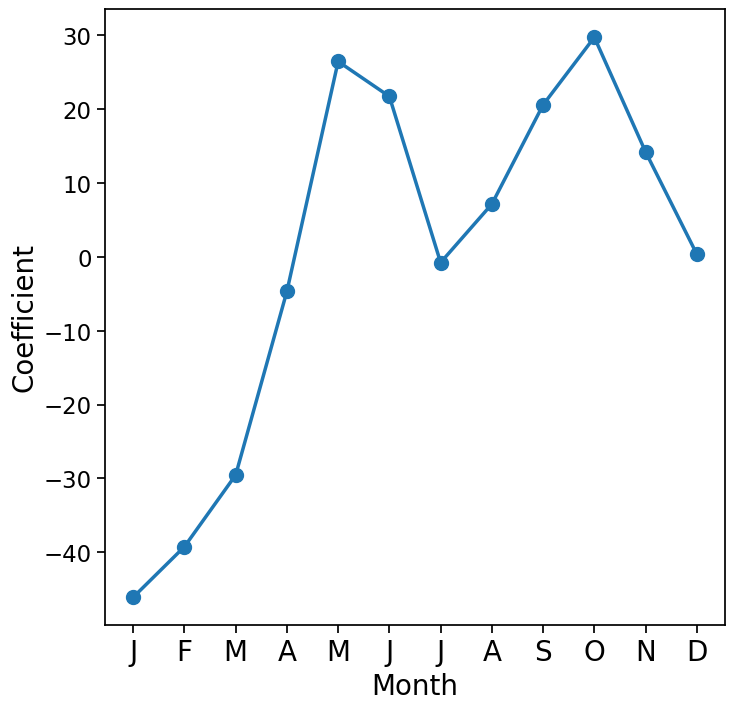

In [93]:
fig_month, ax_month = subplots(figsize=(8,8))
x_month = np.arange(coef_month.shape[0])
ax_month.plot(x_month, coef_month, marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize=20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20);

重現圖4.13右側的繪圖遵循類似的過程。

In [94]:
coef_hr = S2[S2.index.str.contains('hr')]['coef']
coef_hr = coef_hr.reindex(['hr[{0}]'.format(h) for h in range(23)])
coef_hr = pd.concat([coef_hr,
                     pd.Series([-coef_hr.sum()], index=['hr[23]'])
                    ])

現在我們製作小時圖表。

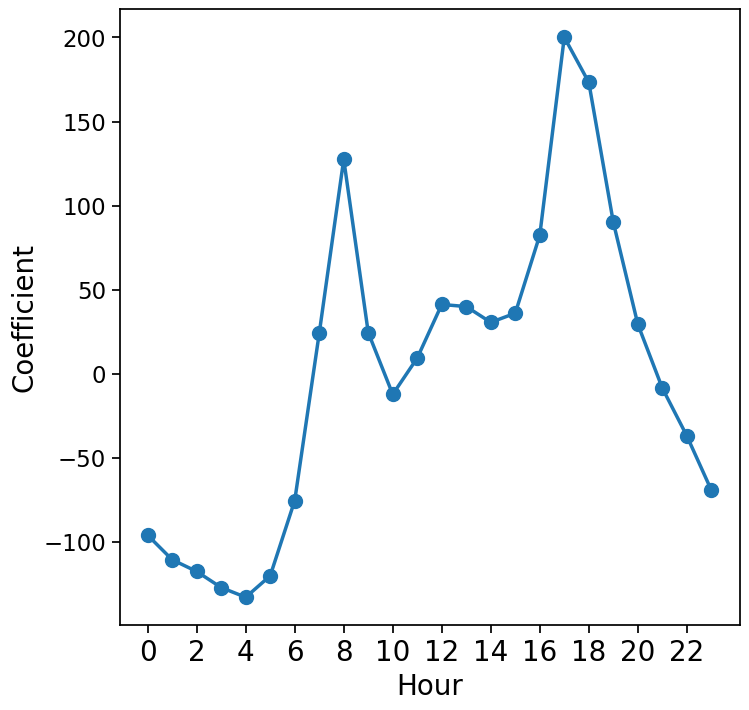

In [95]:
fig_hr, ax_hr = subplots(figsize=(8,8))
x_hr = np.arange(coef_hr.shape[0])
ax_hr.plot(x_hr, coef_hr, marker='o', ms=10)
ax_hr.set_xticks(x_hr[::2])
ax_hr.set_xticklabels(range(24)[::2], fontsize=20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20);

### Poisson Regression

現在我們改為對 `Bikeshare` 資料擬合泊松迴歸模型。幾乎沒有什麼變化，除了我們現在使用 `sm.GLM()` 函數並指定泊松分布族：

In [96]:
M_pois = sm.GLM(Y, X2, family=sm.families.Poisson()).fit()

我們可以繪製與 `mnth` 和 `hr` 相關聯的係數，以重現圖4.15。我們首先如前面一樣完成這些係數。

In [97]:
S_pois = summarize(M_pois)
coef_month = S_pois[S_pois.index.str.contains('mnth')]['coef']
coef_month = pd.concat([coef_month,
                        pd.Series([-coef_month.sum()],
                                   index=['mnth[Dec]'])])
coef_hr = S_pois[S_pois.index.str.contains('hr')]['coef']
coef_hr = pd.concat([coef_hr,
                     pd.Series([-coef_hr.sum()],
                     index=['hr[23]'])])

繪圖和之前一樣。

/tmp/ipython-input-3779510511.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_hr.set_xticklabels(range(24)[::2], fontsize=20)


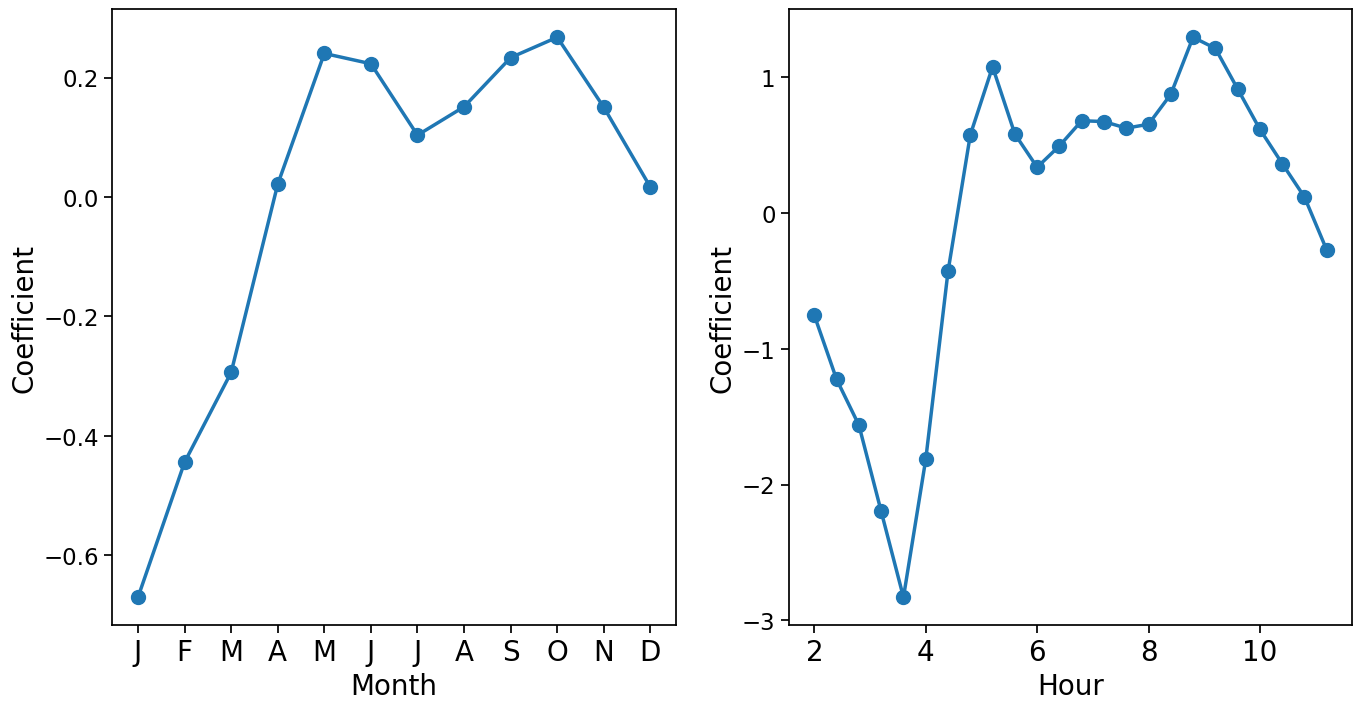

In [98]:
fig_pois, (ax_month, ax_hr) = subplots(1, 2, figsize=(16,8))
ax_month.plot(x_month, coef_month, marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize=20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20)
ax_hr.plot(x_hr, coef_hr, marker='o', ms=10)
ax_hr.set_xticklabels(range(24)[::2], fontsize=20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20);

我們比較兩個模型的擬合值。
擬合值儲存在線性迴歸和泊松擬合的 `fit()` 方法回傳的 `fittedvalues` 屬性中。線性預測值儲存為 `lin_pred` 屬性。

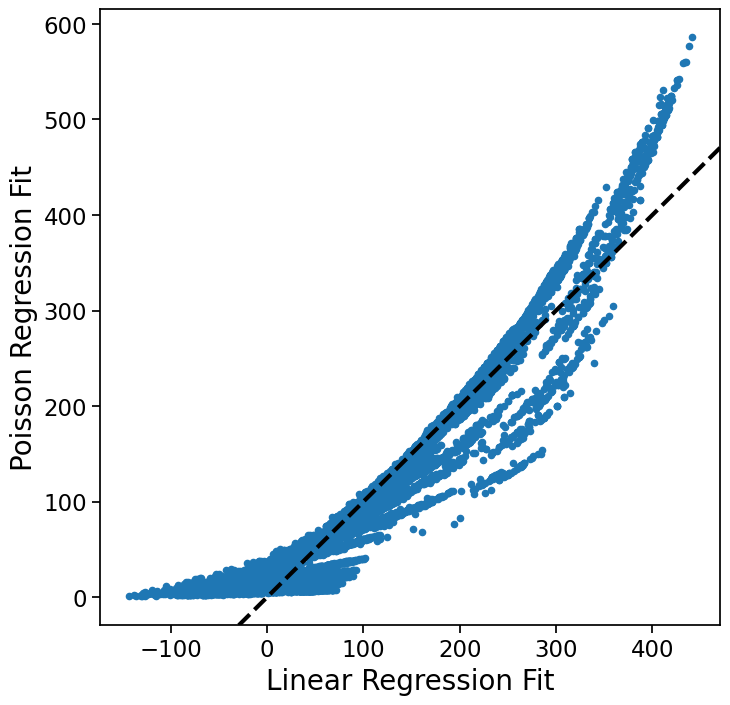

In [99]:
fig, ax = subplots(figsize=(8, 8))
ax.scatter(M2_lm.fittedvalues,
           M_pois.fittedvalues,
           s=20)
ax.set_xlabel('Linear Regression Fit', fontsize=20)
ax.set_ylabel('Poisson Regression Fit', fontsize=20)
ax.axline([0,0], c='black', linewidth=3,
          linestyle='--', slope=1);

泊松迴歸的預測與線性模型的預測相關；然而，前者是非負的。因此，對於非常低或非常高的騎乘水準，泊松迴歸預測往往比線性模型的預測更大。

在本節中，我們使用 `sm.GLM()` 函數擬合泊松迴歸模型，參數為 `family=sm.families.Poisson()`。本實驗的早期我們使用 `sm.GLM()` 函數擬合邏輯迴歸，參數為 `family=sm.families.Binomial()`。`family` 參數的其他選擇可以用來擬合其他類型的 GLM。例如，`family=sm.families.Gamma()` 擬合伽瑪迴歸模型。

## `Sklearn` 中邏輯迴歸的更多資訊

In [100]:
Smarket['Direction2'] = pd.get_dummies(Smarket.Direction, drop_first=True)
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction2
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,True
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,True
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,False
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,True
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,True


C 是正則化項，其中較高的 C 表示對係數幅度的懲罰較少。我們將 C 設定為任意高的值，使得實際上沒有正則化。

In [101]:
X = Smarket.loc[:, 'Lag1':'Volume']
y = Smarket.Direction2
logreg = LogisticRegression(solver='newton-cg', C=1e42)  #large C for no regularization
logreg.fit(X, y)

LogisticRegression(C=1e+42, solver='newton-cg')

In [102]:
print("Intercept:", logreg.intercept_)
list(zip(X.columns, logreg.coef_[0]) )         # coefficients

Intercept: [-0.12584491]


[('Lag1', np.float64(-0.0730591561923254)),
 ('Lag2', np.float64(-0.042288599204942955)),
 ('Lag3', np.float64(0.011080850867559711)),
 ('Lag4', np.float64(0.009367095235006478)),
 ('Lag5', np.float64(0.010310671616211235)),
 ('Volume', np.float64(0.13531761320749033))]

In [103]:
list( zip(X.index, logreg.predict_proba(X=X)[:10, 1]) )

[(0, np.float64(0.5070847416955957)),
 (1, np.float64(0.48146703198586605)),
 (2, np.float64(0.48114185248723707)),
 (3, np.float64(0.5152228279649168)),
 (4, np.float64(0.5107837929043205)),
 (5, np.float64(0.5069587231217716)),
 (6, np.float64(0.49264847507704573)),
 (7, np.float64(0.5092290533694178)),
 (8, np.float64(0.5176139557022594)),
 (9, np.float64(0.4888466744312874))]

In [104]:
y_pred_class = logreg.predict(X=X)
y_pred_class_prob = logreg.predict_proba(X=X)
y_pred_class.sum()

np.int64(964)

In [105]:
print("Accuracy: ", accuracy_score(y, y_pred_class))   # Accuracy
print("Accuracy (manual calculation): %0.7f " % (y == y_pred_class).mean() )

Accuracy:  0.5216
Accuracy (manual calculation): 0.5216000 


In [106]:
logreg.predict([[1.2,1.1,1,1,1,1],
                 [1.5,-0.8,1,1,1,1]])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([False, False])

In [107]:
y

,Direction2
0,True
1,True
2,False
3,True
4,True
...,...
1245,True
1246,False
1247,True
1248,False


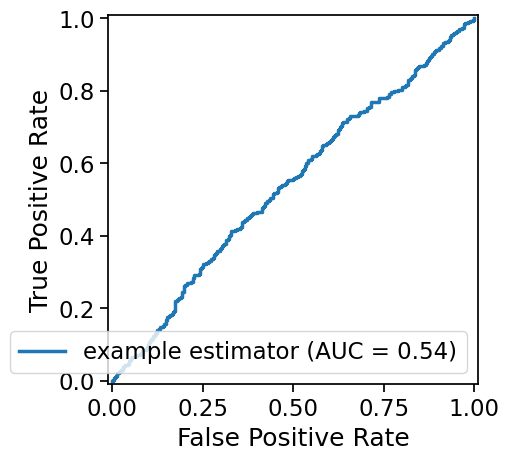

In [108]:
fpr, tpr, thresholds = roc_curve(y, y_pred_class_prob[:,1]) # probability estimates of the positive class, confidence values, or non-thresholded measure of decisions
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator').plot();

## 補充內容

### `scikit-learn` 中的 GLM

[https://github.com/scikit-learn-contrib/skglm](https://github.com/scikit-learn-contrib/skglm).


### 使用 scikit-learn 和欄位轉換進行 Poisson 迴歸

[https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html](https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html).


### Yellowbrick 的繪圖

[https://www.scikit-yb.org/en/latest/api/classifier/index.html#](https://www.scikit-yb.org/en/latest/api/classifier/index.html#).
